## kerasとsequnece to sequence

前回、LSTMによる実装を行いましたので、次はsquence to sequenceモデルを実装していこうと思います。今現在では、機械翻訳などの自然言語処理では、このsequnece to sequenceとAttentionを基本としたモデルがよく利用されています。BERTなどもAttentionモデルが基本となっています。

ここでは、復習もかねて、基本的なsequnece to sequenceを実装します。$y=\exp x$を$y=\log x$に翻訳するモデルの構築を行います。なお、モデルの詳細は検索すればいくらでも出てきますのでここでは割愛します。文献や教科書、技術者によっては、sequnece to sequenceモデルは、「Encoder-Decoderモデル」、「系列変換モデル」などと呼ばれることも多いようです。

以下ではkerasを用いてseq2seqの実装を行いますが、詳細は[公式ブログ](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)を参照してください。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/tree/master/ml/lec/text/seq2seq/seq2seq_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/tree/master/ml/lec/text/seq2seq/seq2seq_nb.ipynb)

### 筆者の環境
筆者のOSはmacOSです。LinuxやUnixのコマンドとはオプションが異なります。

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6032


In [2]:
!python -V

Python 3.8.5


基本的なライブラリとkerasをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np

import tensorflow as tf
from tensorflow import keras
import gensim

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)
print('gensim version : ', gensim.__version__)

matplotlib version : 3.3.2
scipy version : 1.5.2
numpy version : 1.18.5
tensorflow version :  2.3.1
keras version :  2.4.0
gensim version :  3.8.3


## sequence to sequence モデルの入出力データ

最初にsequence to sequence モデルのアルゴリズムの概要と、それをkerasで実行する場合、どのようなデータの入出力になるのかを簡単に説明しようと思います。

### データの入出力のイメージ

![svg](seq2seq_nb_files_local/seq2seq.svg)

sequence to sequence はencoderとdecoderという二つの部分で構成されています。それぞれの部分はRNNやLSTMなどのモデルで構築されます。
このような特徴から時系列データの解析に強く、機械翻訳や音声認識などの分野で利用されているようです。

kerasでseq2seqを実装するには、encoderとdecoderそれぞれへの入力データ（図で言うdataset 1と2）と正解データ（dataset 3)が必要になります。

正解データは、decoderへの入力セットから時系列的に一つずれていることがポイントになります。

以下のサイトを参考にさせていただきました。

- https://blog.octopt.com/sequence-to-sequence/



## サンプルデータ

サンプル用のエンコーダーデータ、デコーダーデータとして、以下の式を利用します。

$$
\text{encoder} : y = \sqrt{x} 
$$

$$
\text{dencoder} : y = x^2
$$


In [4]:
x = np.linspace(0, 1.5, 50)
seq_out = np.array(x ** 0.5)
seq_in = np.array(x ** 2)

# x = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
# seq_in = np.sin(x)
# seq_out = np.cos(x)

# x = np.linspace(0, 5 * np.pi, 50)
# seq_in = np.exp(-x / 5) * (np.cos(x))
# seq_out = np.exp(-x / 5) * (np.sin(x))

### データの確認

$x$と$y$のデータの詳細を見てみます。

In [5]:
print('shape : ', x.shape)
print('ndim : ', x.ndim)
print('data : ', x[:10])

shape :  (50,)
ndim :  1
data :  [0.         0.03061224 0.06122449 0.09183673 0.12244898 0.15306122
 0.18367347 0.21428571 0.24489796 0.2755102 ]


In [6]:
print('shape : ', seq_in.shape)
print('ndim : ', seq_in.ndim)
print('data : ', seq_in[:10])

shape :  (50,)
ndim :  1
data :  [0.         0.00093711 0.00374844 0.00843399 0.01499375 0.02342774
 0.03373594 0.04591837 0.05997501 0.07590587]


In [7]:
print('shape : ', seq_out.shape)
print('ndim : ', seq_out.ndim)
print('data : ', seq_out[:10])

shape :  (50,)
ndim :  1
data :  [0.         0.17496355 0.24743583 0.30304576 0.34992711 0.3912304
 0.42857143 0.46291005 0.49487166 0.52489066]


グラフを確認してみます。

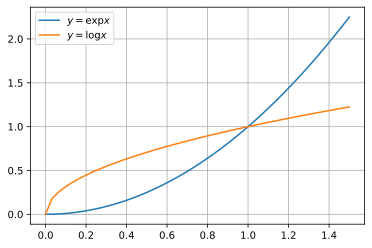

In [8]:
plt.plot(x, seq_in, label='$y=\exp x$')
plt.plot(x, seq_out, label='$y=\log x$')
plt.legend()
plt.grid()
plt.show()

### データの準備

kerasに入力するためのデータをnumpy配列に格納します。

In [9]:
NUM_LSTM = 10 

n = len(x) - NUM_LSTM
ex = np.zeros((n, NUM_LSTM))
dx = np.zeros((n, NUM_LSTM))
dy = np.zeros((n, NUM_LSTM))

for i in range(0, n):
  ex[i] = seq_in[i:i+NUM_LSTM]
  dx[i, 1:] = seq_out[i:i+NUM_LSTM-1]
  dy[i] = seq_out[i:i+NUM_LSTM]

ex = ex.reshape(n, NUM_LSTM, 1)
dx = dx.reshape(n, NUM_LSTM, 1)
dy = dy.reshape(n, NUM_LSTM, 1)

## モデルの構築

sequence to sequenceのモデルをkerasを用いて実装します。
単純なRNNやLSTMとは異なり、モデルが複数あり、それぞれから入力する必要があるため、Sequenceではなく、Modelを利用します。

In [10]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

NUM_MID = 20

e_input = Input(shape=(NUM_LSTM, 1))
e_lstm = LSTM(NUM_MID, return_state=True)
e_output, e_state_h, e_state_c = e_lstm(e_input)
e_state = [e_state_h, e_state_c]

d_input = Input(shape=(NUM_LSTM, 1))
d_lstm = LSTM(NUM_MID, return_sequences=True, return_state=True)
d_output, _, _ = d_lstm(d_input, initial_state=e_state)
d_dense = Dense(1, activation='linear')
d_output = d_dense(d_output)

seq2seq_model = Model([e_input, d_input], d_output)
seq2seq_model.compile(loss="mean_squared_error", optimizer="adam")

# モデルの確認
print(seq2seq_model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 20), (None,  1760        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 10, 20), (No 1760        input_2[0][0]                    
                                                                 lstm[0][1]            

## モデルの学習

In [11]:
# 学習用のパラメタを設定します
batch_size = 8
epochs = 30

history = seq2seq_model.fit([ex, dx], dy, epochs=epochs, batch_size=batch_size, verbose=False)

## 損失関数

損失関数が減少していく様子を可視化してみます。

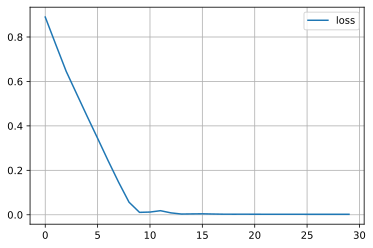

In [12]:
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss, label='loss')
plt.grid()
plt.legend()
plt.show()

十分に収束してる事が分かります。

## 予測するためのencoderとdecoderのモデルを返す関数の作成

### encoderモデルの構築

In [13]:
# encoderのモデルを構築
e_model = Model(e_input, e_state)

In [14]:
# decoderのモデルを構築
d_input = Input(shape=(1, 1))

d_state_in_h = Input(shape=(NUM_MID,))
d_state_in_c = Input(shape=(NUM_MID,))
d_state_in = [d_state_in_h, d_state_in_c]

d_output, d_state_h, d_state_c = d_lstm(d_input, initial_state=d_state_in)
                                                                 
d_state = [d_state_h, d_state_c]

d_output = d_dense(d_output)
d_model = Model([d_input] + d_state_in, [d_output] + d_state)

データを変換するための関数を実装します。

In [15]:
def translate(input_data):
  state_value = e_model.predict(input_data)
  y_decoder = np.zeros((1, 1, 1))
  translated = []
  
  for i in range(0, NUM_LSTM):
    y, h, c = d_model.predict([y_decoder] + state_value)
    y = y[0][0][0]
    translated.append(y)
    dy[0][0][0] = y
    state_value = [h, c]

  return translated

結果の確認

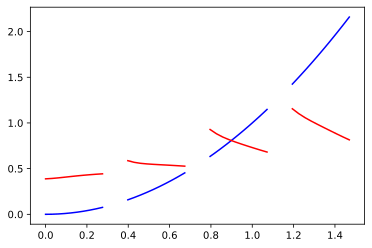

In [16]:
demo_idices = [0, 13, 26, 39]  # デモに使うデータのインデックス
# demo_idices = [0, 13, 26, 39]  # デモに使うデータのインデックス
# demo_idices = [0, 20, 40, 60, 80]  # デモに使うデータのインデックス

for i in demo_idices:
  x_demo = ex[i : i + 1]
  y_demo = translate(x_demo)
  
  plt.plot(x[i : i + NUM_LSTM], x_demo.reshape(-1), color="b")
  plt.plot(x[i : i + NUM_LSTM], y_demo, color="r")

plt.grid()
plt.show()  

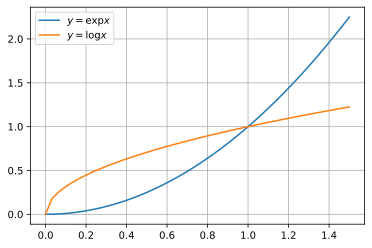

In [17]:
plt.plot(x, seq_in, label='$y=\exp x$')
plt.plot(x, seq_out, label='$y=\log x$')
plt.legend()
plt.grid()
plt.show()